In [1]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn import metrics
import matplotlib.pyplot as plt

In [15]:
# Read data (first leg of journey)
telemetry = pd.read_csv('./telemetry_cleaned.csv')
X = telemetry[['Easting', 'Northing', 'WaterDepth']]

### Windowed Clustering

This technique involves breaking the points into chunks, the size of each chunk being defined by a `window` variable. DBSCAN clustering is then applied to each chunk and a list of labeled chunks is produced.

In [18]:
window_size = 10000

def windowed_clustering(data, verbose=False):
	chunks = []
	results = []
	index = 0

	while index <= data.shape[0]:
		# Get window (chunk)
		chunk = data.iloc[index:index+window_size]

		if verbose:
			print('Starting chunk', index/window_size)

		# Run clustering and append chunk
		db = DBSCAN(eps=0.15, min_samples=9).fit(chunk)
		chunk = chunk.assign(Label=db.labels_)
		chunks.append(chunk)

		silhouette = metrics.silhouette_score(chunk, db.labels_)
		davies_bouldin = metrics.davies_bouldin_score(chunk, db.labels_)

		results.append({
			'silhouette': silhouette,
			'davies_bouldin': davies_bouldin
		})

		if verbose:
			print('Completed chunk', index/window_size)

		index += window_size

	return (chunks, pd.DataFrame(results))

chunks, results = windowed_clustering(X)
print(f'Using a window of {window_size} points, {len(chunks)} chunks were created')

Using a window of 10000 points, 34 chunks were created


Denoise chunks:

In [9]:
X_denoised = pd.concat(chunks)
X_denoised = X_denoised[X_denoised['Label'] != -1]

In [14]:
chunks[0]

,Easting,Northing,WaterDepth,Label
0,0.158187,0.410159,92.93,-1
1,0.158187,0.410159,5.86,-1
2,0.534407,0.535898,5.86,-1
3,0.534311,0.535924,6.33,-1
4,0.533734,0.536254,7.02,-1
...,...,...,...,...
9995,0.510820,0.341917,47.56,11
9996,0.510628,0.342679,47.52,11
9997,0.510555,0.343137,47.49,11
9998,0.510483,0.343365,47.50,11


In [13]:
pd.DataFrame(results)

,silhouette,davies_bouldin
0,0.740366,1.016321
1,0.180938,1.914002
2,0.012264,0.902779
3,0.389480,1.415835
4,0.805022,1.343084
5,-0.283559,0.909483
6,-0.146798,1.134236
7,0.404491,0.307508
8,0.634792,0.580648
9,0.737039,0.649317


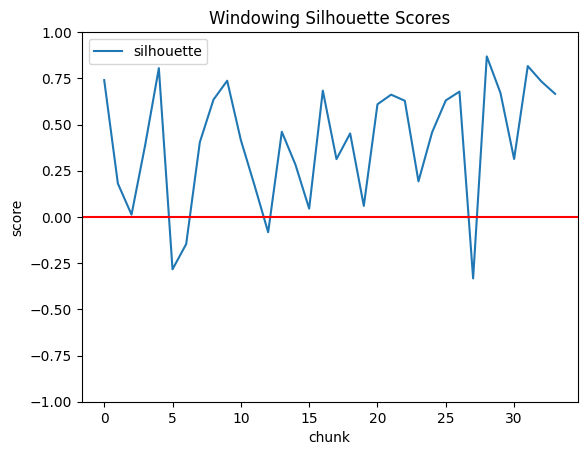

In [29]:
ax = results.plot(y='silhouette', xlabel='chunk', ylabel='score', ylim=(-1,1), title='Windowing Silhouette Scores')
ax.axhline(0, color='red')

<AxesSubplot: xlabel='chunk', ylabel='score'>

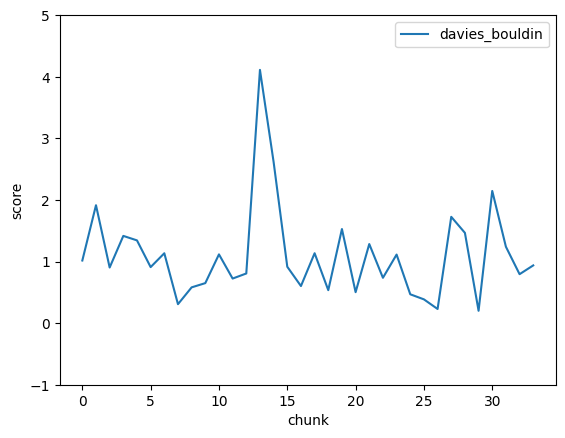

In [24]:
results.plot(y='davies_bouldin', xlabel='chunk', ylabel='score', ylim=(-1,5))